## **Example: A Simple Graph**

Let's build the following graph

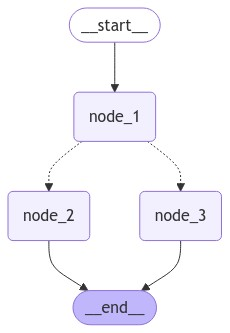

### **Install langraph in quite mode:**

In [ ]:
%%capture --no-stderr
%pip install -qU langgraph

### **Create a State:**
* First of all, we define the state.
* State can be considered as a global state to save inputs and returned outputs
* For State schema, we use TypedDict. However, Pydantic Base Model can also be used.
* TypedDict is used to provide type safety for keys and values to the state dictionary.
* The schema of the State will be the input schema to all Nodes and Edges in the graph.

**Note:** *State takes another parameter (optional), a reducer function, which defines how the state will be updated by nodes.*

In [ ]:
# Define the State schema
from typing import TypedDict

class State (TypedDict):
    graph_state:str

### **Create Nodes:**
Nodes are just python functions where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).
* The first positional argument is the state, as defined above.
* Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].
* Each node returns a new value of the state key graph_state.
* By default, the new value returned by each node will override the prior state value. If we don't want this behaviour, we have to define reducer funciton in State schema that will define the behaviour how nodes updates the state.


In [ ]:
# Create python function for Node-1

def node_1(state:State):
    print("--Node-1--")
    return {"graph_state":state['graph_state']+' I am'}

# Create python function for Node-2
def node_2(state:State):
    print("--Node-2--")
    return {"graph_state":state['graph_state']+' sad'}

# Create python function for Node-3
def node_3(state:State):
    print("--Node-3--")
    return {"graph_state":state['graph_state']+' happy'}

### **Create Edges:**
* Edges connect the nodes.
* Normal Edges are used if you want to always go from, for example, node_1 to node_2.
* Conditional Edges are used want to optionally route between nodes.
* Conditional edges are implemented as functions that return the next node to visit based upon some logic.

### **Create Custom Logic For Our Example:**

In [ ]:
import random
from typing import Literal

# Define the function for condition logic.
# This condition function will decide which node to execute next.
def decide_mood(state) -> Literal['node_2','node_3']:
    print("--Decide Mood--")
    # user_input = state['graph_state']
    if random.random() < 0.5:
        return 'node_3'
    return 'node_2'

### **Build Graph:**
* `START` **Node:**
The `START` Node is a special node that represents the node that sends user input to the graph. The main purpose for referencing this node is to determine which nodes should be called first. It is simply a virtual node which acts as an entry point of our graph. It doesn't perform any operations itself but is crucial for initiating the flow of the graph by sending input to the relevant nodes that perform the actual operations.
* `END` **Node:**
The `END` Node is a special node that represents a terminal node. This node is referenced when you want to denote which edges have no actions after they are done.

In [ ]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

# Build Graph

# Craete instance of StateGraph class.
builder:StateGraph = StateGraph(State)

# Add Nodes in StateGraph
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Define Edges.

# Normal Edge: Connects START node with node-1.
builder.add_edge(START, "node_1")

# Conditional Edge: Decides and connects node-1 with either node-2 or node-3.
# The 'decide_mood' function is used as conditional logic.
builder.add_conditional_edges("node_1", decide_mood)

# Normal Edges: From 'node-2' and 'node-3' to END node.
builder.add_edge("node_3", END)
builder.add_edge("node_2", END)

# Compile the Graph
graph = builder.compile()

### **Display The Graph:**

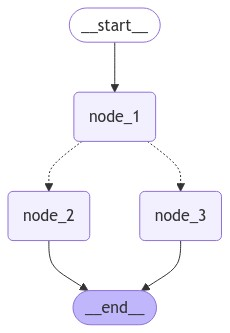

In [ ]:
# Display the Graph
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### **Graph Invokation:**

In [ ]:
# Invoke the Graph
graph.invoke({"graph_state" : "Hi, this is User."})

--Node-1--
--Decide Mood--
--Node-2--


{'graph_state': 'Hi, this is User. I am sad'}